<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/Compara%C3%A7%C3%A3o_Tutorial_w2v_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicando o Word2Vec em um dataset real

Olá. Nesse tutorial vamos demonstrar como utilizar word-embeddings geradas a partir do método Word2Vec, em cima de um corpo de texto do meio jurídico.

O método Word2Vec utiliza o contexto das palavras nos textos para gerar as embbedings. Para isso, foi utilizado o pacote *gensim* (versão 3.6.0), que integra as ferramentas necessárias para gerar, salvar e carregar as embbedings.

As ferramentas de limpeza de texto usadas foram criadas com o enfoque em textos do meio jurídico, mas podem ser usadas com outros textos igualmente. 

Para o funcionamento correto, recomendamos que o usuário tenha acesso aos seguintes módulos:
* ScikitLearn
* Keras
* Gensim
* String
* Numpy
* Pandas
* Ftfy

Neste tutorial, faremos um modelo de Redes Neurais Convolucionais para classificar processos legais em "Ativo", "Suspenso" e "Arquivado". O dataset esta disponível
[nesta página](https://www.kaggle.com/felipepolo/brazilian-legal-proceedings)
do Kaggle. 


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

De início, vamos importar as bibliotecas e funções que serão usadas adiante. Devemos também instalar as bibliotecas que não estão disponíveis por padrão no Google Colab.

In [ ]:
!pip install gensim==3.8.1
!pip install ftfy

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from clean_functions import *


## Carregando os dados

Nosso dataset esta em formato *json*. Para ficar em um formato mais conveniente, vamos transpor o dataset.

In [ ]:
df = pd.read_json("/content/drive/MyDrive/Demos/labeled.json").transpose()

df.head()

,label,texts
0,H:Arquivado,{'-1': 'Tipo do Movimento:Ato Ordinatório Prat...
1,H:Ativo,"{'-1': 'Tipo do Movimento:Recebimento ', '-2':..."
2,H:Ativo,{'-1': 'Tipo do Movimento:RemessaDestinatário:...
3,H:Arquivado,{'-1': 'Tipo do Movimento:Arquivamento Tipo de...
4,H:Arquivado,{'-1': 'Tipo do Movimento:Arquivamento Tipo de...


In [ ]:
df.shape

(6449, 2)

O dataset é composto por um conjunto de 6449 processos classificados nas 3 categorias:
* Ativo
* Suspenso
* Arquivado

Para esse tutorial, iremos apenas utilizar os textos indexados com '-1'. Vamos usar a função "clean" em cada um dos textos.

In [ ]:
X_textos = df.texts[:].apply(lambda dict: clean(dict['-1']))

X_textos.head()

0    tipo do movimento : ato ordinatório praticado ...
1                      tipo do movimento : recebimento
2    tipo do movimento : remessadestinatário : trib...
3    tipo do movimento : arquivamento tipo de arqui...
4    tipo do movimento : arquivamento tipo de arqui...
Name: texts, dtype: object

Agora faremos a separação das categorias da nossa target, numerando de 0 a 2.

In [ ]:
def converte_label(label):
  if label == "H:Ativo": return 0
  elif label == "H:Suspenso": return 1
  else: return 2
labels = array(df.label[:].apply(converte_label))

In [ ]:
labels[:5]

array([2, 0, 0, 2, 2])

Com isso feito, podemos tratar nossos dados para que a rede possa interpreta-los e trabalhar de forma adequada.

## Preparando os dados

O dataset que estamos usando não precisou de muito tratamento. Para as próprias aplicações, o leitor deve verificar com cautela as peculiaridades dos dados, antes de realizar a tokenização.

Com nossos textos tratados, vamos começar a prepará-los para serem recebidos pela rede neural. A estrutura basica da rede neural para NLP deve iniciar com uma camada chamada de "embedding layer". Essa camada é a responsável por traduzir as palavras para vetores. Ela fara isso a partir de uma matriz de pesos, onde cada i-ésima linha contém o vetor referente a i-ésima palavra.

Portanto, devemos indexar cada palavra a um número inteiro, e representar nossos textos como vetores de indexação, ou seja, vetores com os números inteiros referentes a cada palavra. Para isso vamos tokenizar nosso corpo de texto utilizando o objeto *Tokenizer* do Keras. 

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_textos)
tamanho_vocab = len(t.word_index) + 1
encoded_textos = array(t.texts_to_sequences(X_textos))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [ ]:
t.index_word[8], t.index_word[4], t.index_word[39], t.index_word[59], t.index_word[120], t.index_word[185], "..."

('tipo', 'do', 'movimento', 'ato', 'ordinatório', 'praticado', '...')

In [ ]:
print(encoded_textos[0])

[8, 4, 39, 59, 120, 185, 138, 75, 36, 95, 94, 61, 168, 241, 462, 2, 80, 1, 45, 349, 528, 614, 212, 1414, 683, 1415, 36, 684, 685]


Cada vetor agora representa um texto, contúdo, cada um pode ter tamanhos distintos. Devemos padroniza-los, completando os textos menores com "0" até que cheguem no tamanho do maior texto dos dados.

In [ ]:
len_maior = 0
for lista in encoded_textos:
  if len(lista) > len_maior: len_maior = len(lista)

len_maior

306

Vamos usar a função "pad_sequences" do Keras para ajustar o tamanho dos textos para 306. Além disso, é recomendável que passemos os índices para "float".

In [ ]:
padded_docs = pad_sequences(encoded_textos, maxlen=len_maior, padding='post').astype('float32')

len(padded_docs[0])

306

Nossos textos estão prontos para serem recebidos pela rede neural, contudo, ainda é necessário gerar a camada de embbeding da rede. Faremos isso na próxima seção.

Também devemos tratar o nosso vetor de categorias. Por padrão, nossa target deve estar em formato matricial, com 1 na coluna representante da categoria do texto daquela linha e 0 nas demais.

Vamos usar o objeto "OneHotEncoder" do ScikitLearn e passar a matriz para a forma densa (objeto retorna na forma de matriz esparça). 

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
label_onehot = encoder.fit_transform(labels.reshape((-1,1))).todense()

label_onehot[:3]

matrix([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]])

Agora, com nossos dados preparados, começaremos a cuidar da "embbeding layer". 

## Preparando as embeddings

Primeiramente, vamos importar o modelo Word2Vec treinado. Este modelo tem suas embbedings de tamanho 100 e foi treinado usando uma janela de tamanho 15 e "epochs" = 20. Vamos usar o objeto KeyedVectors do *Gensim* para carregar o model.

In [ ]:
model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Demos/cbow_s100.txt")

Com o modelo carregado, já podemos estruturar a matriz de pesos. Neste caso específico, todas as palavras do corpo de texto dos dados estão contidas no vocabulário do modelo Word2Vec, contudo, o leitor deve ter o cuidado de tratar os casos em que essa equivalência não aconteça.

Vamos estruturar um dicionário, no qual cada chave é uma palavra do corpo do vocabulário do modelo e cada valor representa sua embbeding.

In [ ]:
wv_dict = dict(zip(model.wv.index2word[:], model.wv.vectors[:]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Para acelerar o treino da rede, e diminuir o tamanho da matriz de pesos, podemos fazer um dicionário somente com as palavras do texto, pois geralmente, o vocabulário do modelo Word2Vec é muito mais extenso que o necessário. 

In [ ]:
wv_dict_updated = {}
for palavra in t.index_word.values():
  if palavra in wv_dict.keys():
    wv_dict_updated[palavra] = wv_dict[palavra]

Por fim, podemos estruturar a matriz de pesos, colocando a palavra de i-ésimo índice na i-ésima linha da matriz.

In [ ]:
matriz_de_pesos = zeros((tamanho_vocab, 100))
for palavra, i in t.word_index.items():
  vetor_embed =  wv_dict_updated.get(palavra)
  if vetor_embed is not None:
    matriz_de_pesos[i] = vetor_embed

matriz_de_pesos.shape

(2827, 100)

## Treinando o modelo

Com nossos dados codificados, e nossa matriz de pesos pronta, podemos começar a estruturar nossa Rede Neural. Nosso modelo será uma Rede Neural Convolucional, ou seja, aplicaremos uma camada de filtragem e em seguida uma camada de pooling, buscando ressaltar informações importantes das embbedings. 

Nossa rede terá a seguinte estrutura:
1. A primeira camada de embbeding, que fara a codificação das palavras (representadas como índices) nos seus respectivos vetores.
2. A segunda será uma camada convolucional, com 128 filtros no output, kernel de tamanho 5 e função de ativação 'ReLU'.
3. A terceira camada será a MaxPooling de tamanho 2.
4. Como o output da 3ª camada é um tensor, a quarta camada será uma camada de "achatamento".
5. Por fim, a camada do output, de tamanho 3 e função de ativação *softmax*.

In [ ]:
emb = Embedding(tamanho_vocab, 100, weights = [matriz_de_pesos], input_length=len_maior, trainable = False)

rede = Sequential()

rede.add(emb)
rede.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
rede.add(MaxPooling1D(pool_size=2))
rede.add(Flatten())
rede.add(Dense(3, activation='softmax'))

Para terminar a estrutura da rede, vamos usar a função perda como 'categorical_crossentropy', o caso categórico da entropia cruzda, para o otimizador ultilizaremos o 'adam' e a métrica de avaliação será a acurácia. Podemos ver a arquitetura utilizando o método "*Sequential().summary()*".

In [ ]:
rede.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(rede.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 306, 100)          282700    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 302, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 151, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19328)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 57987     
Total params: 404,815
Trainable params: 122,115
Non-trainable params: 282,700
_________________________________________________________________
None


Vamos separar nossos dados em dados de treino e teste.

In [ ]:
n = 4500
X_treino, X_teste, Y_treino, Y_teste = train_test_split(padded_docs, label_onehot, random_state=42, train_size=0.7, test_size=0.3)

Por fim, podemos treinar o modelo e verificar nossos resultados. 

In [ ]:
rede.fit(X_treino, Y_treino, epochs=50, validation_split=0.1, batch_size=500, verbose=1,  callbacks=[EarlyStopping(monitor='val_loss', patience=15)])

Epoch 1/50
9/9 [==============================] - 8s 779ms/step - loss: 0.9694 - accuracy: 0.5044 - val_loss: 0.8539 - val_accuracy: 0.6704
Epoch 2/50
9/9 [==============================] - 7s 731ms/step - loss: 0.7685 - accuracy: 0.6896 - val_loss: 0.7543 - val_accuracy: 0.7080
Epoch 3/50
9/9 [==============================] - 7s 734ms/step - loss: 0.6623 - accuracy: 0.7287 - val_loss: 0.6636 - val_accuracy: 0.7080
Epoch 4/50
9/9 [==============================] - 7s 732ms/step - loss: 0.6111 - accuracy: 0.7484 - val_loss: 0.6236 - val_accuracy: 0.7323
Epoch 5/50
9/9 [==============================] - 7s 746ms/step - loss: 0.5641 - accuracy: 0.7743 - val_loss: 0.5865 - val_accuracy: 0.7788
Epoch 6/50
9/9 [==============================] - 7s 738ms/step - loss: 0.5383 - accuracy: 0.7973 - val_loss: 0.5663 - val_accuracy: 0.7832
Epoch 7/50
9/9 [==============================] - 7s 739ms/step - loss: 0.4913 - accuracy: 0.8135 - val_loss: 0.5352 - val_accuracy: 0.7942
Epoch 8/50
9/9 [====

In [ ]:
loss, acc_treino = rede.evaluate(X_treino, Y_treino, verbose=0)
loss2, acc_teste = rede.evaluate(X_teste, Y_teste, verbose=0)
print(f'Acurácia no treino: {round(acc_treino*100, 2)}%')
print(f'Acurácia no teste: {round(acc_teste*100, 2)}%')

Acurácia no treino: 89.48%
Acurácia no teste: 84.34%


In [ ]:
predict = rede.predict(X_teste)

In [ ]:
Y_teste

matrix([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])

In [ ]:
predict1 = np.argmax(predict, axis=1)

Y_teste1 = np.argmax(Y_teste, axis=1)
np.array(Y_teste1.reshape(1,-1))[0]

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
print(classification_report(Y_teste1, predict1, labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       901
           1       0.86      0.55      0.67       140
           2       0.86      0.85      0.85       894

    accuracy                           0.84      1935
   macro avg       0.85      0.76      0.79      1935
weighted avg       0.84      0.84      0.84      1935



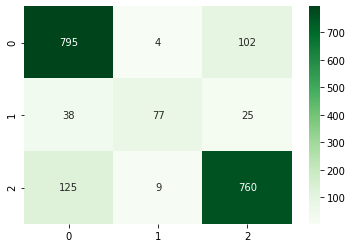

In [ ]:
cm = confusion_matrix(Y_teste1, predict1)
sns.heatmap(cm , fmt=".3g", annot= True, cmap="Greens")

plt.show()

Como a distância entre o score de treino e teste não é tão grande, e ambos performaram bem, podemos dizer que nosso modelo teve uma boa performance no geral. 

Uma analise mais aprofundada nos dados e na arquitetura da rede poderia levar a performances ainda melhores. Essas análises no entanto fogem do escopo deste tutorial, contudo, encorajamos o leitor a elaborar modelos que performem ainda melhor, e a realizar uma análise e engenharia de dados ainda mais aprofundada. 

Esperamos ter ajudado. 

:D